# Automated EPASS-Inspired SSL Experimentation on DBpedia (with Data Download)

This notebook automates the training and evaluation of the EPASS-inspired semi-supervised text classification model on the DBpedia dataset for various percentages of labeled data. 

**Key Change:** It now includes logic to automatically download the DBpedia Ontology dataset, making it more self-contained and reproducible across different environments.

### Goal:

Automatically download the dataset, run training loops for specified labeled data fractions (e.g., 1%, 5%, 10%, 20%, 40%, 60%, 100%), save the best performing model state dictionary (`.pth`) for each configuration, and collect performance metrics.

### Notebook Structure:

1.  **Setup & Imports:** Load libraries, set up the environment.
2.  **Configuration:** Define hyperparameters, data paths, and the list of labeled percentages to test.
3.  **Data Download:** Function to download and extract the DBpedia dataset.
4.  **Utility Functions:** `set_seed`, `load_data`, `simple_tokenizer`, `build_vocab`, `TextClassificationDataset`, `collate_batch`.
5.  **Model Definition:** `TextEncoder`, `EnsembleProjectors`, `EPASS_Model`.
6.  **Loss & Optimizer Definition:** `classification_criterion`, `consistency_loss_fn`.
7.  **Training & Evaluation Functions:** `train_one_epoch`, `evaluate`.
8.  **Main Experiment Loop:** Iterates through percentages, sets up each run, trains, evaluates, saves the best model per percentage, and collects results.
9.  **Results Summary & Visualization:** Prints final results and plots accuracy vs. labeled percentage.

In [1]:
# 1. Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import random
import time
import math
import os
import gc # Garbage collector
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial # For collate function
import requests # For downloading data
import tarfile # For extracting .tar.gz files
import io # For handling byte streams

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Configuration & Hyperparameters --- 

# Percentages of labeled data to test
# Add/remove percentages as needed. 1.0 means fully supervised.
PERCENTAGES_TO_TEST = [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 1.0] 

# Common settings for all runs
SEED = 42
BASE_WORKING_DIR = "/kaggle/working/" # Base directory for downloads and models
DATA_DIR = os.path.join(BASE_WORKING_DIR, "data/dbpedia/")
BASE_MODEL_SAVE_DIR = os.path.join(BASE_WORKING_DIR, "saved_models/") 
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(BASE_MODEL_SAVE_DIR, exist_ok=True)

# Define expected CSV paths after download/extraction
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")

# Data subset sizes (set to None to use full dataset)
NUM_TRAIN_SAMPLES = 50000 # Use a reasonable subset for faster experiments
NUM_TEST_SAMPLES = 10000  

# Vocabulary settings
VOCAB_MAX_SIZE = 25000  
VOCAB_MIN_FREQ = 3

# Model hyperparameters (fixed across runs for fair comparison)
EMBED_DIM = 128          
HIDDEN_DIM = 256         
PROJ_DIM = 128           
NUM_PROJECTORS = 3       
NUM_CLASSES = 14         
DROPOUT = 0.4            

# Training hyperparameters (fixed across runs for fair comparison)
BATCH_SIZE = 64
LEARNING_RATE = 5e-4     
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 30 # Reduce epochs for faster multi-run experiment, increase if needed
LAMBDA_U = 0.8           

# --- Utility Functions --- 
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Using device: cuda


In [2]:
# 3. Data Download Function

DBPEDIA_URL = "https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz"

def download_and_extract_dbpedia(url, target_dir):
    """Downloads and extracts the DBPedia dataset if not already present."""
    train_path = os.path.join(target_dir, "train.csv")
    test_path = os.path.join(target_dir, "test.csv")
    classes_path = os.path.join(target_dir, "classes.txt") # The archive also contains this
    readme_path = os.path.join(target_dir, "readme.txt")

    if os.path.exists(train_path) and os.path.exists(test_path):
        print(f"Dataset already found in {target_dir}")
        return train_path, test_path

    print(f"Downloading DBPedia dataset from {url}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Check content type if possible, although S3 might not provide a reliable one
        # content_type = response.headers.get('content-type')
        # print(f"Content-Type: {content_type}")
        
        # Use tarfile to extract directly from the byte stream
        # mode='r:gz' handles gzip decompression automatically
        with tarfile.open(fileobj=io.BytesIO(response.content), mode='r:gz') as tar:
            # Extract only necessary files to avoid potential path issues
            members_to_extract = []
            expected_files = ['dbpedia_csv/train.csv', 'dbpedia_csv/test.csv', 
                              'dbpedia_csv/classes.txt', 'dbpedia_csv/readme.txt']
            for member in tar.getmembers():
                if member.name in expected_files and member.isfile():
                    # Remove the base directory 'dbpedia_csv/' before extracting
                    member.name = os.path.basename(member.name)
                    members_to_extract.append(member)
            
            if not members_to_extract:
                 raise ValueError("Could not find expected files (train.csv, test.csv) in the archive.")
            
            print(f"Extracting files to {target_dir}...")
            tar.extractall(path=target_dir, members=members_to_extract)
        
        # Verify extraction
        if not (os.path.exists(train_path) and os.path.exists(test_path)):
             raise FileNotFoundError("Extraction failed or train.csv/test.csv not found after extraction.")
             
        print("Dataset downloaded and extracted successfully.")
        return train_path, test_path

    except requests.exceptions.RequestException as e:
        print(f"Error downloading dataset: {e}")
        raise
    except tarfile.TarError as e:
        print(f"Error extracting dataset: {e}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

# --- Execute Download --- 
print("Checking for DBPedia dataset...")
TRAIN_CSV, TEST_CSV = download_and_extract_dbpedia(DBPEDIA_URL, DATA_DIR)
print(f"Using Train CSV: {TRAIN_CSV}")
print(f"Using Test CSV: {TEST_CSV}")

Checking for DBPedia dataset...
Extracting files to /kaggle/working/data/dbpedia/...
Dataset downloaded and extracted successfully.
Using Train CSV: /kaggle/working/data/dbpedia/train.csv
Using Test CSV: /kaggle/working/data/dbpedia/test.csv


In [3]:
# 4. Data Loading & Vocab Utilities (CORRECTED)

def load_data(csv_path, num_samples=None, seed=42):
    """Loads data, renames columns, handles labels, and subsamples."""
    # Check if file exists before reading
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found at {csv_path}. Please ensure download was successful.")
        
    # Read CSV - Specify no header since the downloaded files don't have one
    df = pd.read_csv(csv_path, header=None)
    
    # RENAME columns *FIRST*
    df.columns = ['label', 'title', 'content'] 
    
    # NOW modify the label column
    df['label'] = df['label'] - 1 # Map labels 1-14 to 0-13
    
    # Combine title and content
    df["text"] = df["title"].astype(str) + " " + df["content"].astype(str)
    
    # Select final columns needed (label and combined text)
    df = df[['label', 'text']]
    
    # Subsampling logic (remains the same, accesses 'label' after renaming)
    if num_samples is not None and num_samples < len(df):
        print(f"Subsampling to {num_samples} samples...")
        try:
            min_samples_per_group = 1
            required_total_samples = df['label'].nunique() * min_samples_per_group
            # Check if unique labels match expected NUM_CLASSES before stratification
            if num_samples >= required_total_samples and df['label'].nunique() == NUM_CLASSES:
                 df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(max(min_samples_per_group, int(np.rint(num_samples * len(x) / len(df)))), random_state=seed))
                 print(f"  Stratified sample size: {len(df)}")
                 if len(df) > num_samples:
                     df = df.sample(n=num_samples, random_state=seed)
                 elif len(df) < num_samples:
                     print(f"  Warning: Stratified sampling resulted in {len(df)} samples. Topping up randomly.")
                     # Load full data again *with correct column handling* for topping up
                     full_df_temp = pd.read_csv(csv_path, header=None)
                     full_df_temp.columns = ['label', 'title', 'content']
                     full_df_temp['label'] = full_df_temp['label'] - 1
                     full_df_temp['text'] = full_df_temp['title'].astype(str) + " " + full_df_temp['content'].astype(str)
                     
                     # Find indices not already sampled
                     # We need to compare with the original full_df_temp index before it got potentially reset
                     # Need to ensure df's index hasn't been reset yet for this comparison to work if it came from groupby.apply
                     # Let's get indices from full load and exclude df's current indices
                     all_indices = pd.read_csv(csv_path, header=None).index 
                     # If df.index was reset, we need another way. Assume for now it reflects original rows.
                     # It's safer to do sampling on the full df *before* returning.
                     # Let's adjust the logic slightly: sample indices first from full df
                     indices_to_exclude = df.index # Assuming df index hasn't been reset by groupby
                     additional_indices = all_indices.difference(indices_to_exclude)
                     
                     additional_samples = full_df_temp.loc[additional_indices].sample(n=num_samples - len(df), random_state=seed)
                     df = pd.concat([df, additional_samples[['label', 'text']]], ignore_index=True)
            else:
                 print(f"  Not enough samples/classes ({df['label'].nunique()}) for stratification, using random sampling.")
                 df = df.sample(n=num_samples, random_state=seed)
        except Exception as e:
            print(f"  Stratified sampling failed ({e}), falling back to random sampling.")
            df = df.sample(n=num_samples, random_state=seed)
            
    return df.reset_index(drop=True)

def simple_tokenizer(text):
    return text.lower().split()

def build_vocab(texts, max_size=None, min_freq=2, specials=["<unk>", "<pad>"]):
    print(f"Building vocabulary (max_size={max_size}, min_freq={min_freq})...")
    counter = Counter()
    for i, text in enumerate(texts):
        tokens = simple_tokenizer(str(text)) # Ensure text is string
        counter.update(tokens)
        if (i+1) % 10000 == 0:
             print(f'\r  Processed {i+1}/{len(texts)} texts for vocab', end='')
    print('\r  Finished processing texts for vocab.')

    vocab = {token: idx for idx, token in enumerate(specials)}
    vocab_idx = len(specials)
    words_and_freqs = sorted(counter.items(), key=lambda item: item[1], reverse=True)
    added_tokens = 0
    for word, freq in words_and_freqs:
        if max_size and vocab_idx >= max_size:
            break
        if freq < min_freq:
            continue
        if word not in vocab:
            vocab[word] = vocab_idx
            vocab_idx += 1
            added_tokens += 1
            
    itos = {idx: token for token, idx in vocab.items()}
    print(f"Vocabulary size: {len(vocab)} (added {added_tokens} tokens)")
    return vocab, itos

class TextClassificationDataset(Dataset):
    def __init__(self, df, vocab, tokenizer, unk_idx):
        self.labels = df['label'].tolist()
        self.texts = df['text'].tolist()
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.unk_idx = unk_idx

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.texts[idx]
        # Handle potential NaN/float values in text column if sampling caused issues
        text_str = str(text) if pd.notna(text) else "" 
        tokens = self.tokenizer(text_str)
        indices = [self.vocab.get(token, self.unk_idx) for token in tokens]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_batch(batch, pad_idx):
    label_list, text_list, lengths = [], [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        processed_text = _text
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    text_list = pad_sequence(text_list, batch_first=True, padding_value=pad_idx)
    label_list = torch.stack(label_list)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return text_list, label_list, lengths

In [4]:
# 5. Model Definition (No changes needed here)
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.embed_dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.pad_idx = pad_idx
        
    def forward(self, text, lengths):
        embedded = self.embed_dropout(self.embedding(text))
        mask = (text != self.pad_idx).unsqueeze(-1).float()
        non_zero_lengths = lengths.unsqueeze(1).float().clamp(min=1)
        summed_embeddings = torch.sum(embedded * mask, dim=1)
        avg_pooled = summed_embeddings / non_zero_lengths
        out = self.fc1(avg_pooled)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

class EnsembleProjectors(nn.Module):
    def __init__(self, input_dim, proj_dim, num_projectors, dropout):
        super().__init__()
        self.num_projectors = num_projectors
        self.projectors = nn.ModuleList()
        for _ in range(num_projectors):
            self.projectors.append(
                nn.Sequential(
                    nn.Linear(input_dim, input_dim // 2),
                    nn.BatchNorm1d(input_dim // 2),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(input_dim // 2, proj_dim)
                )
            )

    def forward(self, x):
        proj_outputs = [proj(x) for proj in self.projectors]
        ensemble_output = torch.stack(proj_outputs, dim=0).mean(dim=0)
        return ensemble_output

class EPASS_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, proj_dim, num_classes, 
                 num_projectors, dropout, pad_idx):
        super().__init__()
        self.encoder = TextEncoder(vocab_size, embed_dim, hidden_dim, dropout, pad_idx)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.projector = EnsembleProjectors(hidden_dim, proj_dim, num_projectors, dropout)
    
    def forward(self, text, lengths):
        features = self.encoder(text, lengths)
        logits = self.classifier(features)
        projection = self.projector(features)
        return logits, projection

In [5]:
# 6. Loss & Optimizer Definition (No changes needed here)
classification_criterion = nn.CrossEntropyLoss()

def consistency_loss_fn(proj1, proj2):
    proj1 = F.normalize(proj1, p=2, dim=1)
    proj2 = F.normalize(proj2, p=2, dim=1)
    cos_sim = F.cosine_similarity(proj1, proj2, dim=1)
    loss = 1.0 - cos_sim.mean()
    return loss

In [6]:
# 7. Training and Evaluation Functions (No changes needed here)
def train_one_epoch(model, labeled_loader, unlabeled_loader, optimizer, 
                    classification_criterion, consistency_criterion, lambda_u, device, epoch_num, total_epochs):
    model.train()
    total_loss, total_cls_loss, total_cons_loss = 0.0, 0.0, 0.0
    total_labeled_correct, total_labeled_samples = 0, 0
    
    # Determine iteration count based on the longer loader if semi-supervised
    # If fully supervised, use labeled loader length
    if len(unlabeled_loader) > 0:
        num_batches_per_epoch = max(len(labeled_loader), len(unlabeled_loader))
    else:
        num_batches_per_epoch = len(labeled_loader)
        
    labeled_iter = iter(labeled_loader) if len(labeled_loader) > 0 else None
    unlabeled_iter = iter(unlabeled_loader) if len(unlabeled_loader) > 0 else None
    
    print(f"    Training epoch {epoch_num}/{total_epochs} ({num_batches_per_epoch} effective batches)...", end='')
    start_time = time.time()
    
    for i in range(num_batches_per_epoch):
        optimizer.zero_grad()
        loss_cls = torch.tensor(0.0, device=device) # Initialize losses for the batch
        loss_cons = torch.tensor(0.0, device=device)

        # --- Labeled Data --- 
        if labeled_iter:
            try:
                text_lab, labels, lengths_lab = next(labeled_iter)
            except StopIteration:
                labeled_iter = iter(labeled_loader) # Reset iterator
                text_lab, labels, lengths_lab = next(labeled_iter)
            text_lab, labels, lengths_lab = text_lab.to(device), labels.to(device), lengths_lab.to(device)
            
            logits_lab, _ = model(text_lab, lengths_lab)
            loss_cls = classification_criterion(logits_lab, labels)
            
            preds_lab = logits_lab.argmax(dim=1)
            total_labeled_correct += (preds_lab == labels).sum().item()
            total_labeled_samples += labels.size(0)

        # --- Unlabeled Data --- 
        if unlabeled_iter:
            try:
                text_unlab, _, lengths_unlab = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader) # Reset iterator
                text_unlab, _, lengths_unlab = next(unlabeled_iter)
            text_unlab, lengths_unlab = text_unlab.to(device), lengths_unlab.to(device)

            _, proj_unlab1 = model(text_unlab, lengths_unlab)
            _, proj_unlab2 = model(text_unlab, lengths_unlab)
            loss_cons = consistency_criterion(proj_unlab1, proj_unlab2)
        
        # --- Total Loss & Backpropagation ---
        current_lambda_u = lambda_u if unlabeled_iter else 0.0 # Lambda is 0 if no unlabeled data
        epoch_batch_loss = loss_cls + current_lambda_u * loss_cons
        
        if epoch_batch_loss > 0: # Avoid backward pass if loss is zero (e.g., only unlabeled and lambda=0)
            epoch_batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        total_loss += epoch_batch_loss.item()
        total_cls_loss += loss_cls.item()
        total_cons_loss += loss_cons.item()
        
        if (i+1) % 100 == 0:
             print('.', end='')

    epoch_duration = time.time() - start_time
    print(f" Done ({epoch_duration:.2f}s)") 
    avg_loss = total_loss / num_batches_per_epoch
    avg_cls_loss = total_cls_loss / max(1, len(labeled_loader)) # Average over actual labeled batches
    avg_cons_loss = total_cons_loss / max(1, len(unlabeled_loader)) # Average over actual unlabeled batches
    train_acc = total_labeled_correct / total_labeled_samples * 100 if total_labeled_samples > 0 else 0.0
    
    return avg_loss, avg_cls_loss, avg_cons_loss, train_acc

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    print(f"    Evaluating... ({len(data_loader)} batches)", end='')
    start_time = time.time()
    with torch.no_grad():
        for i, (text, labels, lengths) in enumerate(data_loader):
            text, labels, lengths = text.to(device), labels.to(device), lengths.to(device)
            logits, _ = model(text, lengths)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if (i+1) % 100 == 0:
                 print('.', end='')
    eval_duration = time.time() - start_time
    print(f" Done ({eval_duration:.2f}s)")
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds) * 100
    return avg_loss, accuracy, all_labels, all_preds

In [7]:
# --- Pre-load data and build vocab once ---
# Ensure data is downloaded before proceeding
if not (os.path.exists(TRAIN_CSV) and os.path.exists(TEST_CSV)):
    print("Dataset not found, attempting download...")
    TRAIN_CSV, TEST_CSV = download_and_extract_dbpedia(DBPEDIA_URL, DATA_DIR)
else:
    print("Dataset found.")
    
print("Loading full dataset subset for vocab and testing...")
df_train_full_for_vocab = load_data(TRAIN_CSV, NUM_TRAIN_SAMPLES, seed=SEED)
df_test = load_data(TEST_CSV, NUM_TEST_SAMPLES, seed=SEED)

print(f"\nFull train samples for vocab: {len(df_train_full_for_vocab)}, Test samples: {len(df_test)}")

vocab, itos = build_vocab(df_train_full_for_vocab["text"].tolist(), 
                          max_size=VOCAB_MAX_SIZE, 
                          min_freq=VOCAB_MIN_FREQ)
UNK_IDX = vocab["<unk>"]
PAD_IDX = vocab["<pad>"]
VOCAB_SIZE = len(vocab)

# We still need the full training data loaded to create subsets later
print("\nLoading full training data subset again for splitting...")
df_train_full = load_data(TRAIN_CSV, NUM_TRAIN_SAMPLES, seed=SEED)

# Create the full dataset objects once
full_train_dataset = TextClassificationDataset(df_train_full, vocab, simple_tokenizer, UNK_IDX)
test_dataset = TextClassificationDataset(df_test, vocab, simple_tokenizer, UNK_IDX)

# Collate function with padding index bound
collate_fn_with_pad = partial(collate_batch, pad_idx=PAD_IDX)

# Test loader (created once)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, 
                         collate_fn=collate_fn_with_pad, num_workers=2, pin_memory=True)

# Dictionary to store results
experiment_results = {}

Dataset found.
Loading full dataset subset for vocab and testing...
Subsampling to 50000 samples...
  Stratified sample size: 49994


/tmp/ipykernel_19/1611221284.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(max(min_samples_per_group, int(np.rint(num_samples * len(x) / len(df)))), random_state=seed))


Subsampling to 10000 samples...
  Stratified sample size: 9996


/tmp/ipykernel_19/1611221284.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(max(min_samples_per_group, int(np.rint(num_samples * len(x) / len(df)))), random_state=seed))



Full train samples for vocab: 50000, Test samples: 10000
Building vocabulary (max_size=25000, min_freq=3)...
  Finished processing texts for vocab.
Vocabulary size: 25000 (added 24998 tokens)

Loading full training data subset again for splitting...
Subsampling to 50000 samples...
  Stratified sample size: 49994


/tmp/ipykernel_19/1611221284.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(max(min_samples_per_group, int(np.rint(num_samples * len(x) / len(df)))), random_state=seed))


In [8]:
# 8. Main Experiment Loop

print("\n===== Starting Automated Experimentation =====")

for percentage in PERCENTAGES_TO_TEST:
    print(f"\n--- Running Experiment for {percentage*100:.1f}% Labeled Data ---")
    current_labeled_percentage = percentage
    current_model_save_path = os.path.join(BASE_MODEL_SAVE_DIR, f"epass_dbpedia_best_{int(percentage*100)}pct.pth")
    
    # --- Reproducibility & Setup for this run ---
    print("  Setting up run...")
    set_seed(SEED) # Reset seed for each percentage run
    
    # --- Data Splitting for this percentage ---
    num_total_train = len(full_train_dataset)
    num_labeled = int(current_labeled_percentage * num_total_train)
    if current_labeled_percentage > 0 and num_labeled == 0: num_labeled = 1 
    num_unlabeled = num_total_train - num_labeled
    print(f"    Splitting {num_total_train} into {num_labeled} labeled and {num_unlabeled} unlabeled samples.")
    
    indices = np.random.permutation(num_total_train)
    labeled_indices = indices[:num_labeled]
    unlabeled_indices = indices[num_labeled:]
    
    labeled_dataset = Subset(full_train_dataset, labeled_indices)
    
    if num_unlabeled > 0:
        unlabeled_dataset = Subset(full_train_dataset, unlabeled_indices)
        # Use num_workers=0 if issues arise in interactive environments like Kaggle notebooks
        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                  collate_fn=collate_fn_with_pad, drop_last=True, num_workers=0, pin_memory=True)
    else:
        unlabeled_loader = [] 
        
    if num_labeled > 0:
         labeled_loader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                 collate_fn=collate_fn_with_pad, drop_last=True, num_workers=0, pin_memory=True)
    else: 
        print("    Warning: No labeled data. Training will rely solely on consistency loss.")
        labeled_loader = []
        
    print(f"    Labeled batches: {len(labeled_loader)}, Unlabeled batches: {len(unlabeled_loader)}")

    # --- Model, Optimizer, Scheduler Initialization ---
    print("    Initializing model, optimizer, scheduler...")
    model = EPASS_Model(
        vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, 
        proj_dim=PROJ_DIM, num_classes=NUM_CLASSES, num_projectors=NUM_PROJECTORS, 
        dropout=DROPOUT, pad_idx=PAD_IDX
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
    
    # --- Training Loop for this percentage ---
    best_test_accuracy_this_run = 0.0
    run_training_stats = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'cls_loss': [], 'cons_loss': []}
    print(f"  Starting training for {NUM_EPOCHS} epochs...")
    run_start_time = time.time()
    
    for epoch in range(1, NUM_EPOCHS + 1):
        avg_train_loss, avg_cls_loss, avg_cons_loss, train_acc = train_one_epoch(
            model, labeled_loader, unlabeled_loader, optimizer, 
            classification_criterion, consistency_loss_fn, LAMBDA_U, device, epoch, NUM_EPOCHS
        )
        
        # Evaluation
        test_loss, test_accuracy, _, _ = evaluate(model, test_loader, classification_criterion, device)
        
        # Store stats
        run_training_stats['train_loss'].append(avg_train_loss)
        run_training_stats['cls_loss'].append(avg_cls_loss)
        run_training_stats['cons_loss'].append(avg_cons_loss)
        run_training_stats['train_acc'].append(train_acc)
        run_training_stats['test_loss'].append(test_loss)
        run_training_stats['test_acc'].append(test_accuracy)
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"    Epoch {epoch:2d} Summary: TrainLoss={avg_train_loss:.4f}, TrainAcc(Lbl)={train_acc:.2f}%, TestLoss={test_loss:.4f}, TestAcc={test_accuracy:.2f}%, LR={current_lr:.6f}")
        
        if test_accuracy > best_test_accuracy_this_run:
            best_test_accuracy_this_run = test_accuracy
            torch.save(model.state_dict(), current_model_save_path)
            print(f"      >> Best model for {percentage*100:.1f}% saved (Acc: {best_test_accuracy_this_run:.2f}%) <<")
    
    run_duration = time.time() - run_start_time
    print(f"  Finished training for {percentage*100:.1f}%. Total time: {run_duration // 60:.0f}m {run_duration % 60:.0f}s")
    print(f"  Best Test Accuracy for this run: {best_test_accuracy_this_run:.2f}% (Model saved to {current_model_save_path})")
    
    # Store final result for this percentage
    experiment_results[percentage] = {
        'best_test_accuracy': best_test_accuracy_this_run,
        'final_test_loss': test_loss, # Loss at last epoch
        'model_path': current_model_save_path,
        'training_stats': run_training_stats 
    }
    
    # --- Cleanup for next run --- 
    print("  Cleaning up GPU memory...")
    del model, optimizer, scheduler, labeled_loader, unlabeled_loader, labeled_dataset
    if 'unlabeled_dataset' in locals(): del unlabeled_dataset
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n===== Automated Experimentation Finished! =====")


===== Starting Automated Experimentation =====

--- Running Experiment for 1.0% Labeled Data ---
  Setting up run...
    Splitting 50000 into 500 labeled and 49500 unlabeled samples.
    Labeled batches: 7, Unlabeled batches: 773
    Initializing model, optimizer, scheduler...
  Starting training for 30 epochs...
    Training epoch 1/30 (773 effective batches).......... Done (12.56s)
    Evaluating... (79 batches) Done (0.63s)
    Epoch  1 Summary: TrainLoss=0.6591, TrainAcc(Lbl)=81.46%, TestLoss=0.9339, TestAcc=73.48%, LR=0.000499
      >> Best model for 1.0% saved (Acc: 73.48%) <<
    Training epoch 2/30 (773 effective batches).......... Done (12.05s)
    Evaluating... (79 batches) Done (0.57s)
    Epoch  2 Summary: TrainLoss=0.0343, TrainAcc(Lbl)=99.20%, TestLoss=0.9985, TestAcc=75.22%, LR=0.000495
      >> Best model for 1.0% saved (Acc: 75.22%) <<
    Training epoch 3/30 (773 effective batches).......... Done (11.91s)
    Evaluating... (79 batches) Done (0.55s)
    Epoch  3 Summa


===== Experiment Summary =====
Percentage Labeled | Best Test Accuracy (%)
-------------------|------------------------
               1.0% |                  79.00%
               5.0% |                  89.63%
              10.0% |                  92.34%
              20.0% |                  94.13%
              40.0% |                  95.17%
              60.0% |                  95.42%
             100.0% |                  96.61%


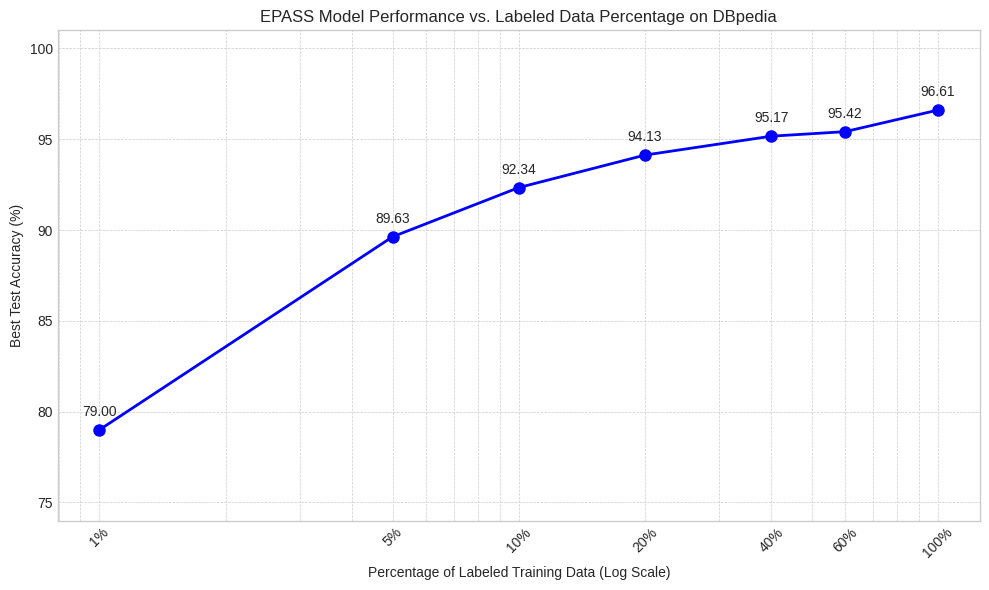


--- Evaluating Best Model for 10% Labeled Data ---
Loading model from: /kaggle/working/saved_models/epass_dbpedia_best_10pct.pth
    Evaluating... (79 batches)

/tmp/ipykernel_19/2976117627.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model.load_state_dict(torch.load(best_10pct_path))


 Done (0.57s)
  Final Test Accuracy (10% Labeled): 92.34%

Classification Report (10% Run):

                        precision    recall  f1-score   support

               Company     0.8781    0.8375    0.8573       714
EducationalInstitution     0.9451    0.9636    0.9542       714
                Artist     0.8188    0.8669    0.8422       714
               Athlete     0.9361    0.9440    0.9400       714
          OfficeHolder     0.9292    0.9006    0.9147       714
  MeanOfTransportation     0.9131    0.9566    0.9343       714
              Building     0.9236    0.8978    0.9105       714
          NaturalPlace     0.9554    0.9594    0.9574       715
               Village     0.9860    0.9832    0.9846       714
                Animal     0.8880    0.9216    0.9045       714
                 Plant     0.9318    0.8992    0.9152       714
                 Album     0.9726    0.9427    0.9574       715
                  Film     0.9561    0.9441    0.9500       715
          

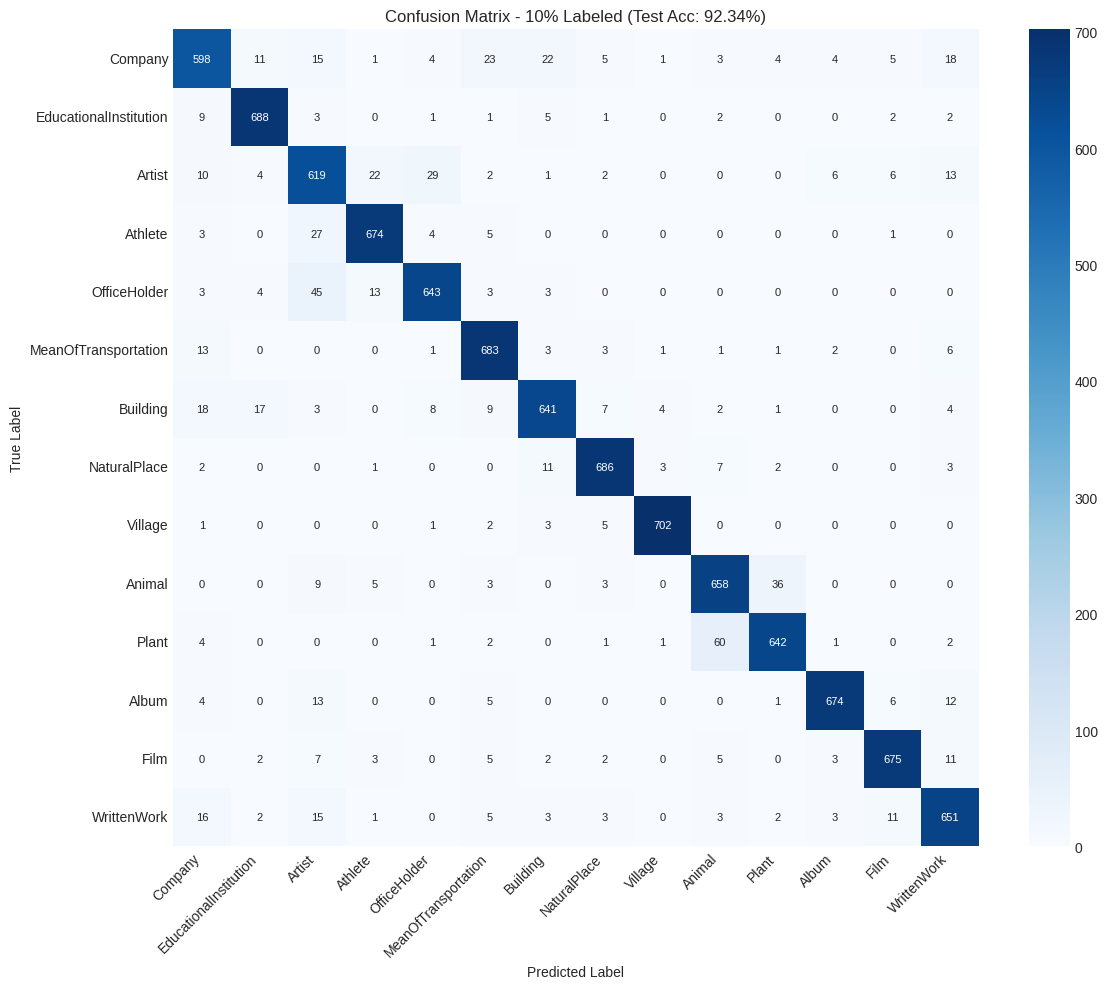

In [9]:
# 9. Results Summary & Visualization

print("\n===== Experiment Summary =====")

sorted_percentages = sorted(experiment_results.keys())
accuracies = [experiment_results[p]['best_test_accuracy'] for p in sorted_percentages]
percentage_labels = [f"{p*100:.0f}%" for p in sorted_percentages]

print("Percentage Labeled | Best Test Accuracy (%)")
print("-------------------|------------------------")
for i, p in enumerate(sorted_percentages):
    print(f"{p*100:>18.1f}% | {accuracies[i]:>22.2f}%" )

# Plotting Accuracy vs Labeled Percentage
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(sorted_percentages, accuracies, 'bo-', markersize=8, linewidth=2)
plt.title('EPASS Model Performance vs. Labeled Data Percentage on DBpedia')
plt.xlabel('Percentage of Labeled Training Data (Log Scale)')
plt.ylabel('Best Test Accuracy (%)')
plt.gca().set_xscale('log') # Use log scale for x-axis if percentages vary widely
# Ensure ticks cover the tested range, even on log scale
plt.xticks(sorted_percentages, labels=percentage_labels, rotation=45) 
# plt.minorticks_off() # Optional: turn off minor ticks if log scale looks cluttered

plt.ylim(bottom=max(0, min(accuracies)-5) if accuracies else 0, top=101) # Adjust y-axis limits
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Annotate points
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2f}', (sorted_percentages[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Example: Load and evaluate the best model for a specific percentage (e.g., 10%)
if 0.1 in experiment_results:
    print("\n--- Evaluating Best Model for 10% Labeled Data ---")
    best_10pct_path = experiment_results[0.1]['model_path']
    print(f"Loading model from: {best_10pct_path}")
    
    # Need to re-initialize the model architecture before loading state_dict
    eval_model = EPASS_Model(
        vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, 
        proj_dim=PROJ_DIM, num_classes=NUM_CLASSES, num_projectors=NUM_PROJECTORS, 
        dropout=DROPOUT, pad_idx=PAD_IDX
    ).to(device)
    
    if os.path.exists(best_10pct_path):
        eval_model.load_state_dict(torch.load(best_10pct_path))
        
        # Evaluate on the test set
        final_test_loss, final_test_accuracy, all_labels, all_preds = evaluate(
            eval_model, test_loader, classification_criterion, device
        )
        print(f"  Final Test Accuracy (10% Labeled): {final_test_accuracy:.2f}%")
        
        # Display classification report/confusion matrix for this run
        print("\nClassification Report (10% Run):\n")
        class_names = [ 
            'Company', 'EducationalInstitution', 'Artist', 'Athlete', 'OfficeHolder', 
            'MeanOfTransportation', 'Building', 'NaturalPlace', 'Village', 'Animal', 
            'Plant', 'Album', 'Film', 'WrittenWork'
        ]
        if len(class_names) != NUM_CLASSES: class_names = [f'Class {i}' for i in range(NUM_CLASSES)]
        print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))
        
        print("\nConfusion Matrix (10% Run):")
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 8})
        plt.title(f"Confusion Matrix - 10% Labeled (Test Acc: {final_test_accuracy:.2f}%)")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"Model file not found at {best_10pct_path}")
        
    del eval_model # Clean up model
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()